In [1]:
import pandas as pd               # We use pandas for data analysis and processing.
import requests
import json
from pandas import json_normalize

In [2]:
import numpy as np                # We use numpy for multi-dimensional arrays and mathematical operations.
import seaborn as sns             # We use seaborn for a high-level interface for data visualization.
import matplotlib.pyplot as plt   # We use matplotlib.pyplot for creating plots and graphs.
#%matplotlib inline                # We enable the inline backend for matplotlib in Jupyter notebooks.
sns.set(color_codes=True)         # We configure seaborn to use color codes for enhanced visualization

In [3]:
import math                       # We import the math module for access to mathematical functions.

In [4]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [5]:
# API URL'si
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ROA04/JSON-stat/1.0/en"

In [6]:
# API'den veri çekmek için GET isteği yapılıyor
res = requests.get(url)

# Eğer istek başarılıysa (HTTP 200), veriyi al
if res.status_code == 200:
    data = res.json()  # JSON formatındaki veriyi Python sözlüğüne dönüştürür
    print("Response=",res.status_code,"\n")
    print("Response successful")
else:
    print("API'den veri çekilemedi. Hata kodu:", response.status_code)

Response= 200 

Response successful


In [7]:
data.keys()

dict_keys(['dataset'])

In [8]:
data['dataset']

{'dimension': {'STATISTIC': {'label': 'Statistic',
   'category': {'index': {'ROA04C1': 0, 'ROA04C2': 1},
    'label': {'ROA04C1': 'Full Driving Licences',
     'ROA04C2': 'Learner Permit Driving Licences'},
    'unit': {'ROA04C1': {'base': 'Number'}, 'ROA04C2': {'base': 'Number'}}}},
  'TLIST(A1)': {'label': 'Year',
   'category': {'index': {'2009': 0,
     '2010': 1,
     '2011': 2,
     '2012': 3,
     '2013': 4,
     '2014': 5,
     '2015': 6,
     '2016': 7,
     '2017': 8,
     '2018': 9,
     '2019': 10,
     '2020': 11,
     '2021': 12,
     '2022': 13},
    'label': {'2009': '2009',
     '2010': '2010',
     '2011': '2011',
     '2012': '2012',
     '2013': '2013',
     '2014': '2014',
     '2015': '2015',
     '2016': '2016',
     '2017': '2017',
     '2018': '2018',
     '2019': '2019',
     '2020': '2020',
     '2021': '2021',
     '2022': '2022'}}},
  'C02076V03371': {'label': 'Age Group',
   'category': {'index': {'-': 0,
     '336': 1,
     '3401': 2,
     '385': 3,
    

In [9]:
data['dataset'].keys()

dict_keys(['dimension', 'label', 'source', 'updated', 'value'])

In [10]:
data['dataset']['value']

[2362292.0,
 1294008.0,
 1068284.0,
 3.0,
 1.0,
 2.0,
 46258.0,
 28631.0,
 17627.0,
 132124.0,
 71179.0,
 60945.0,
 249341.0,
 127963.0,
 121378.0,
 566068.0,
 296445.0,
 269623.0,
 500679.0,
 267591.0,
 233088.0,
 405903.0,
 226276.0,
 179627.0,
 291517.0,
 171512.0,
 120005.0,
 134121.0,
 81528.0,
 52593.0,
 36278.0,
 22882.0,
 13396.0,
 2375171.0,
 1292281.0,
 1082890.0,
 0.0,
 0.0,
 0.0,
 41718.0,
 25845.0,
 15873.0,
 126959.0,
 68734.0,
 58225.0,
 241544.0,
 123865.0,
 117679.0,
 572293.0,
 297541.0,
 274752.0,
 504463.0,
 267944.0,
 236519.0,
 409716.0,
 225584.0,
 184132.0,
 297029.0,
 172528.0,
 124501.0,
 141722.0,
 85394.0,
 56328.0,
 39727.0,
 24846.0,
 14881.0,
 2395131.0,
 1296193.0,
 1098938.0,
 0.0,
 0.0,
 0.0,
 39488.0,
 24301.0,
 15187.0,
 121162.0,
 65881.0,
 55281.0,
 234366.0,
 120376.0,
 113990.0,
 575269.0,
 297384.0,
 277885.0,
 512629.0,
 271109.0,
 241520.0,
 415673.0,
 226358.0,
 189315.0,
 304716.0,
 174972.0,
 129744.0,
 148759.0,
 88973.0,
 59786.0,
 43069.

In [11]:
data['dataset']['label']

'Current Full and Learner Permit Driving Licences'

In [12]:
data['dataset']['dimension'].keys()

dict_keys(['STATISTIC', 'TLIST(A1)', 'C02076V03371', 'C02199V02655', 'role', 'id', 'size'])

In [13]:
# Anahtarları yinelemeli olarak bulan fonksiyon
def find_keys(data, path=None):
    if path is None:
        path = []
    if isinstance(data, dict):
        for k, v in data.items():
            yield path + [k]
            yield from find_keys(v, path + [k])
    elif isinstance(data, list):
        for item in data:
            yield from find_keys(item, path + ["list-item"])

# Fonksiyonu test edelim
keys_list = list(find_keys(data))
for key_path in keys_list:
    print(" -> ".join(key_path))

dataset
dataset -> dimension
dataset -> dimension -> STATISTIC
dataset -> dimension -> STATISTIC -> label
dataset -> dimension -> STATISTIC -> category
dataset -> dimension -> STATISTIC -> category -> index
dataset -> dimension -> STATISTIC -> category -> index -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> index -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> label
dataset -> dimension -> STATISTIC -> category -> label -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> label -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> unit
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C1 -> base
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C2 -> base
dataset -> dimension -> TLIST(A1)
dataset -> dimension -> TLIST(A1) -> label
dataset -> dimension -> TLIST(A1) -> category
dataset -> dimension 

In [14]:
# Boyutlar ve etiketler
dimensions = data['dataset']['dimension']
values = data['dataset']['value']  # Değerlerin listesi

# DataFrame sütunlarını oluşturmak için boyutlardan indeks ve etiketleri çıkar
stats = list(dimensions['STATISTIC']['category']['label'].values())
years = list(dimensions['TLIST(A1)']['category']['label'].values())
age_groups = list(dimensions['C02076V03371']['category']['label'].values())
sex = list(dimensions['C02199V02655']['category']['label'].values())
#values=data['dataset']['value']


In [15]:
# Converting each string in the list to an integer
int_years = [int(year) for year in years]
int_years

[2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [16]:
# JSON verisini düz bir tabloya dönüştüren fonksiyon
#def process_json_data(data):
# Veri çerçevesini oluşturacak verileri toplayacak listeler
stats_list, years_list ,int_years_list, age_groups_list, sex_list = [], [], [], [], []

# JSON-stat değerlerinin çok boyutlu dizilimini düzleştirmek için her bir boyut boyunca döngü
for stat_label in stats:
    for year in int_years:
        for age_label in age_groups:
            for sex_label in sex:
                stats_list.append(stat_label)
                int_years_list.append(year)
                age_groups_list.append(age_label)
                sex_list.append(sex_label)

# DataFrame oluştur
df = pd.DataFrame({
    'Statistic': stats_list,
    'Year': int_years_list,
    'Age Group': age_groups_list,
    'Sex': sex_list,
    'Value': values
})
df
# Fonksiyonu çağırarak verileri işle ve DataFrame oluştur
#df = process_json_data(data)
#df

,Statistic,Year,Age Group,Sex,Value
0,Full Driving Licences,2009,All ages,Both sexes,2362292.0
1,Full Driving Licences,2009,All ages,Male,1294008.0
2,Full Driving Licences,2009,All ages,Female,1068284.0
3,Full Driving Licences,2009,Under 17 years,Both sexes,3.0
4,Full Driving Licences,2009,Under 17 years,Male,1.0
...,...,...,...,...,...
919,Learner Permit Driving Licences,2022,70 - 79 years,Male,523.0
920,Learner Permit Driving Licences,2022,70 - 79 years,Female,1111.0
921,Learner Permit Driving Licences,2022,80 years and over,Both sexes,236.0
922,Learner Permit Driving Licences,2022,80 years and over,Male,64.0


In [17]:
# # JSON verisini düz bir tabloya dönüştüren fonksiyon
# def process_json_data(data):
#     # Veri çerçevesini oluşturacak verileri toplayacak listeler
#     stats_list, years_list ,int_years_list, age_groups_list, sex_list = [], [], [], [], []

#     # JSON-stat değerlerinin çok boyutlu dizilimini düzleştirmek için her bir boyut boyunca döngü
#     for stat_label in stats:
#         for year in int_years:
#             for age_label in age_groups:
#                 for sex_label in sex:
#                     stats_list.append(stat_label)
#                     int_years_list.append(year)
#                     age_groups_list.append(age_label)
#                     sex_list.append(sex_label)
                    
#     # DataFrame oluştur
#     df = pd.DataFrame({
#         'Statistic': stats_list,
#         'Year': int_years_list,
#         'Age Group': age_groups_list,
#         'Sex': sex_list,
#         'Value': values
#     })
    
#     return df
# # Fonksiyonu çağırarak verileri işle ve DataFrame oluştur
# df = process_json_data(data)
# df

In [18]:
df2=pd.read_csv("People_with_a_driving_licence_22122023_160245.csv",sep=';') #We read the second data set with pandas
#veri setimiz noktali virgul ile ayrildigi icin sep parametresini ';' olarak ayarliyoruz

In [19]:
df2.head()

,Periods,Age driving license holder,Passenger car driving licence total,Passenger car licence excl. trailer,Passenger car licence incl. trailer
0,2014,Total,2381440.0,1185966.0,1195474.0
1,2014,16 to 17 years,3230.0,3230.0,NaN
2,2014,18 to 19 years,41200.0,40467.0,733.0
3,2014,20 to 24 years,163919.0,155859.0,8060.0
4,2014,25 to 29 years,172310.0,157944.0,14366.0


In [20]:
df2.isnull().sum()                        # We count the number of null values in each column of the dataframe

Periods                                 0
Age driving license holder              1
Passenger car driving licence total     1
Passenger car licence excl. trailer     1
Passenger car licence incl. trailer    11
dtype: int64

In [21]:
df2.duplicated().sum()                    # We count the total number of duplicated rows in the dataframe

0

In [22]:
missing_df2 = df2[df2.isna().any(axis=1)] # We create a new dataframe containing only the rows with missing data.
missing_df2 # We display the dataframe with missing values.

,Periods,Age driving license holder,Passenger car driving licence total,Passenger car licence excl. trailer,Passenger car licence incl. trailer
1,2014,16 to 17 years,3230.0,3230.0,NaN
13,2015,16 to 17 years,3869.0,3869.0,NaN
25,2016,16 to 17 years,4252.0,4252.0,NaN
37,2017,16 to 17 years,4383.0,4383.0,NaN
49,2018,16 to 17 years,4736.0,4736.0,NaN
61,2019,16 to 17 years,4444.0,4444.0,NaN
73,2020,16 to 17 years,4358.0,4358.0,NaN
85,2021,16 to 17 years,2744.0,2744.0,NaN
97,2022,16 to 17 years,2220.0,2220.0,NaN
109,2023,16 to 17 years,3050.0,3050.0,NaN


In [23]:
# We drop the specified columns from the dataframe and apply changes directly with inplace=True.
df2.drop(columns=["Passenger car licence excl. trailer"], inplace=True)
df2.drop(columns=["Passenger car licence incl. trailer"], inplace=True)
df2 = df2.drop(index=120)
df2

,Periods,Age driving license holder,Passenger car driving licence total
0,2014,Total,2381440.0
1,2014,16 to 17 years,3230.0
2,2014,18 to 19 years,41200.0
3,2014,20 to 24 years,163919.0
4,2014,25 to 29 years,172310.0
...,...,...,...
115,2023,50 to 59 years,504071.0
116,2023,60 to 64 years,244904.0
117,2023,65 to 69 years,209807.0
118,2023,70 to 74 years,186232.0


In [24]:
df2.isnull().sum() # We count the number of null values in each column of the dataframe

Periods                                0
Age driving license holder             0
Passenger car driving licence total    0
dtype: int64

In [25]:
df2 = df2.rename(columns={"Periods":"Year",
                        "Age driving license holder":"Age Group",
                        "Passenger car driving licence total": "Value"}) # We rename 'VALUE' to 'Value' to match the naming style of other columns.

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       120 non-null    object 
 1   Age Group  120 non-null    object 
 2   Value      120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB


In [27]:
df["Value"] = df["Value"].astype(int)
#df2['Value'] = df2['Value'].str.replace(',', '.').astype(float)
df2["Year"] = df2["Year"].astype(int)
df2["Value"] = df2["Value"].astype(int)
print("Ireland dtypes:\n",df.dtypes,"\n")
print("Netherlands dtypes:\n",df2.dtypes)

Ireland dtypes:
 Statistic    object
Year          int64
Age Group    object
Sex          object
Value         int32
dtype: object 

Netherlands dtypes:
 Year          int32
Age Group    object
Value         int32
dtype: object


In [28]:
df = df[df["Sex"] == "Both sexes"].reset_index(drop=True)
df.drop(columns=["Sex"], inplace=True)
df

,Statistic,Year,Age Group,Value
0,Full Driving Licences,2009,All ages,2362292
1,Full Driving Licences,2009,Under 17 years,3
2,Full Driving Licences,2009,17 - 20 years,46258
3,Full Driving Licences,2009,21 - 24 years,132124
4,Full Driving Licences,2009,25 - 29 years,249341
...,...,...,...,...
303,Learner Permit Driving Licences,2022,40 - 49 years,38111
304,Learner Permit Driving Licences,2022,50 - 59 years,15412
305,Learner Permit Driving Licences,2022,60 - 69 years,5125
306,Learner Permit Driving Licences,2022,70 - 79 years,1634


In [29]:
df["Statistic"].unique()

array(['Full Driving Licences', 'Learner Permit Driving Licences'],
      dtype=object)

In [30]:
# Yıl ve yaş grubuna göre gruplandır ve 'Value' sütunu için toplam al
total_licences = df.groupby(["Year", "Age Group"]).sum().reset_index()

# Yeni bir 'Statistic' sütunu ekle ve 'Total Licences' olarak adlandır
total_licences["Statistic"] = "Total Licences"

# Bu toplamı orijinal df DataFrame'ine ekle
df = pd.concat([df, total_licences], ignore_index=True)
df = df[(df["Year"] >= 2014) & (df["Statistic"] == "Total Licences")].reset_index(drop=True)
df.drop(columns=["Statistic"], inplace=True)
df

,Year,Age Group,Value
0,2014,17 - 20 years,87492
1,2014,21 - 24 years,150032
2,2014,25 - 29 years,245595
3,2014,30 - 39 years,629313
4,2014,40 - 49 years,568308
...,...,...,...
94,2022,60 - 69 years,452487
95,2022,70 - 79 years,273037
96,2022,80 years and over,94761
97,2022,All ages,3325487


In [31]:
df2 = df2[(df2["Year"] <= 2022)].reset_index(drop=True)
df2

,Year,Age Group,Value
0,2014,Total,2381440
1,2014,16 to 17 years,3230
2,2014,18 to 19 years,41200
3,2014,20 to 24 years,163919
4,2014,25 to 29 years,172310
...,...,...,...
103,2022,50 to 59 years,510566
104,2022,60 to 64 years,240066
105,2022,65 to 69 years,206217
106,2022,70 to 74 years,186056


In [32]:
print("Ireland age group unique:\n",f"Total= {df['Age Group'].nunique()}\n",df["Age Group"].unique(),"\n")
print("Netherlands age group unique:\n",f"Total= {df2['Age Group'].nunique()}\n",df2["Age Group"].unique(),"\n")

Ireland age group unique:
 Total= 11
 ['17 - 20 years' '21 - 24 years' '25 - 29 years' '30 - 39 years'
 '40 - 49 years' '50 - 59 years' '60 - 69 years' '70 - 79 years'
 '80 years and over' 'All ages' 'Under 17 years'] 

Netherlands age group unique:
 Total= 12
 ['Total' '16 to 17 years' '18 to 19 years' '20 to 24 years'
 '25 to 29 years' '30 to 39 years' '40 to 49 years' '50 to 59 years'
 '60 to 64 years' '65 to 69 years' '70 to 74 years' '75 years or older'] 



In [33]:
df2['Age Group'] = df2['Age Group'].replace({"16 to 17 years": "Under 17 years","Total":"All ages"})
df2['Age Group'] = df2['Age Group'].str.replace("to","-")
df2['Age Group'] = df2['Age Group'].str.replace("or older","and over")

In [34]:
# Adım 1: İlgili yaş gruplarını filtrele
age_groups_to_combine = df['Age Group'].isin(['17 - 20 years', '21 - 24 years'])
age_groups_to_combine2 = df['Age Group'].isin(['70 - 79 years', '80 years and over'])
# Adım 2: Yıl bazında bu grupların 'Value' değerlerini topla
combined_values = df[age_groups_to_combine].groupby("Year")["Value"].sum().reset_index()
combined_values2 = df[age_groups_to_combine2].groupby("Year")["Value"].sum().reset_index()
# Adım 3: 'Age Group' sütunu ekleyip '60 - 69 years' olarak ayarla
combined_values['Age Group'] = "17 - 24 years"
combined_values2['Age Group'] = "70 years and over"
# Adım 4: Orijinal verileri kaldır (isteğe bağlı)
df = df[~age_groups_to_combine]
df = df[~age_groups_to_combine2]
# Adım 5: Yeni değerleri ekleyin
df = pd.concat([df, combined_values, combined_values2], ignore_index=True)

# DataFrame'i yeniden sıralayın (isteğe bağlı)
df = df.sort_values(by=['Year', 'Age Group']).reset_index(drop=True)

In [35]:
# Adım 1: İlgili yaş gruplarını filtrele
age_groups_to_combine21 = df2['Age Group'].isin(['60 - 64 years', '65 - 69 years'])
age_groups_to_combine22 = df2['Age Group'].isin(['18 - 19 years', '20 - 24 years'])
age_groups_to_combine23 = df2['Age Group'].isin(['70 - 74 years', '75 years and over'])
# Adım 2: Yıl bazında bu grupların 'Value' değerlerini topla
combined_values21 = df2[age_groups_to_combine21].groupby("Year")["Value"].sum().reset_index()
combined_values22 = df2[age_groups_to_combine22].groupby("Year")["Value"].sum().reset_index()
combined_values23 = df2[age_groups_to_combine23].groupby("Year")["Value"].sum().reset_index()
# Adım 3: 'Age Group' sütunu ekleyip '60 - 69 years' olarak ayarla
combined_values21['Age Group'] = "60 - 69 years"
combined_values22['Age Group'] = "17 - 24 years"
combined_values23['Age Group'] = "70 years and over"
# Adım 4: Orijinal verileri kaldır (isteğe bağlı)
df2 = df2[~age_groups_to_combine21]
df2 = df2[~age_groups_to_combine22]
df2 = df2[~age_groups_to_combine23]
# Adım 5: Yeni değerleri ekleyin
df2 = pd.concat([df2, combined_values21,combined_values22,combined_values23], ignore_index=True)

# DataFrame'i yeniden sıralayın (isteğe bağlı)
df2 = df2.sort_values(by=['Year', 'Age Group']).reset_index(drop=True)

In [36]:
print("Ireland age group unique:\n",f"Total= {df['Age Group'].nunique()}\n",df["Age Group"].unique(),"\n")
print("Netherlands age group unique:\n",f"Total= {df2['Age Group'].nunique()}\n",df2["Age Group"].unique(),"\n")

Ireland age group unique:
 Total= 9
 ['17 - 24 years' '25 - 29 years' '30 - 39 years' '40 - 49 years'
 '50 - 59 years' '60 - 69 years' '70 years and over' 'All ages'
 'Under 17 years'] 

Netherlands age group unique:
 Total= 9
 ['17 - 24 years' '25 - 29 years' '30 - 39 years' '40 - 49 years'
 '50 - 59 years' '60 - 69 years' '70 years and over' 'All ages'
 'Under 17 years'] 



In [37]:
Ireland = df
Netherlands = df2

In [38]:
Ireland

,Year,Age Group,Value
0,2014,17 - 24 years,237524
1,2014,25 - 29 years,245595
2,2014,30 - 39 years,629313
3,2014,40 - 49 years,568308
4,2014,50 - 59 years,454946
...,...,...,...
76,2022,50 - 59 years,601477
77,2022,60 - 69 years,452487
78,2022,70 years and over,367798
79,2022,All ages,3325487


In [39]:
Netherlands

,Year,Age Group,Value
0,2014,17 - 24 years,205119
1,2014,25 - 29 years,172310
2,2014,30 - 39 years,356824
3,2014,40 - 49 years,494320
4,2014,50 - 59 years,489610
...,...,...,...
76,2022,50 - 59 years,510566
77,2022,60 - 69 years,446283
78,2022,70 years and over,408747
79,2022,All ages,2524888


In [40]:
total_rows = df.shape[0]                 # We assign the number of rows to "total_rows"
total_columns = df.shape[1]              # We assign the number of columns to "total_columns"
total_rows2 = df2.shape[0]                 # We assign the number of rows to "total_rows"
total_columns2 = df2.shape[1]              # We assign the number of columns to "total_columns"
print(f"Ireland Total Rows= {total_rows}")       # We print the total number of rows
print(f"Ireland Total Columns= {total_columns}") # We print the total number of columns
print(f"Netherlands Total Rows= {total_rows2}")       # We print the total number of rows
print(f"Netherlands Total Columns= {total_columns2}") # We print the total number of columns

Ireland Total Rows= 81
Ireland Total Columns= 3
Netherlands Total Rows= 81
Netherlands Total Columns= 3


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       81 non-null     int64 
 1   Age Group  81 non-null     object
 2   Value      81 non-null     int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.7+ KB


In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       81 non-null     int32 
 1   Age Group  81 non-null     object
 2   Value      81 non-null     int32 
dtypes: int32(2), object(1)
memory usage: 1.4+ KB


In [43]:
# pd.set_option('display.max_rows', None)  # Tüm satırları göstermek için
# print(df)
# pd.reset_option('display.max_rows')

with pd.option_context('display.max_rows', None):
    print(df,"\n")
with pd.option_context('display.max_rows', None):
    print(df2)

    Year          Age Group    Value
0   2014      17 - 24 years   237524
1   2014      25 - 29 years   245595
2   2014      30 - 39 years   629313
3   2014      40 - 49 years   568308
4   2014      50 - 59 years   454946
5   2014      60 - 69 years   340771
6   2014  70 years and over   232928
7   2014           All ages  2710664
8   2014     Under 17 years     1279
9   2015      17 - 24 years   238607
10  2015      25 - 29 years   240823
11  2015      30 - 39 years   632343
12  2015      40 - 49 years   582279
13  2015      50 - 59 years   468059
14  2015      60 - 69 years   352209
15  2015  70 years and over   248461
16  2015           All ages  2764069
17  2015     Under 17 years     1288
18  2016      17 - 24 years   239640
19  2016      25 - 29 years   235873
20  2016      30 - 39 years   637360
21  2016      40 - 49 years   597842
22  2016      50 - 59 years   479959
23  2016      60 - 69 years   363360
24  2016  70 years and over   265128
25  2016           All ages  2820528
2

In [44]:
print(df.describe(),"\n")
print(df2.describe())

              Year         Value
count    81.000000  8.100000e+01
mean   2018.000000  6.614900e+05
std       2.598076  8.494945e+05
min    2014.000000  1.243000e+03
25%    2016.000000  2.396400e+05
50%    2018.000000  3.884350e+05
75%    2020.000000  6.230160e+05
max    2022.000000  3.325487e+06 

              Year         Value
count    81.000000  8.100000e+01
mean   2018.000000  5.462181e+05
std       2.598076  6.964024e+05
min    2014.000000  2.220000e+03
25%    2016.000000  2.063670e+05
50%    2018.000000  3.727390e+05
75%    2020.000000  4.641840e+05
max    2022.000000  2.524888e+06


In [45]:
#df.to_csv('Ireland.csv', index=False)
#df2.to_csv('Netherlands.csv', index=False)

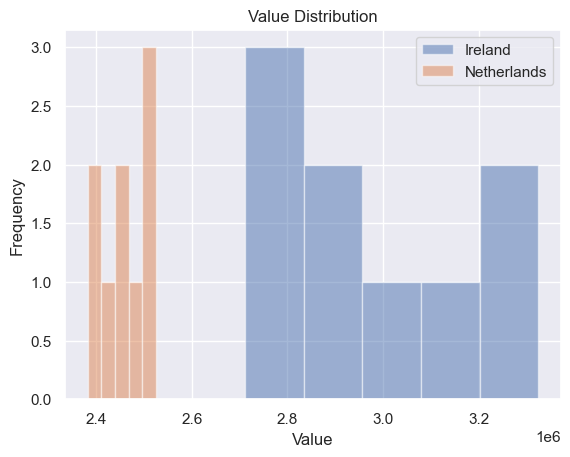

In [46]:
# Histograms for the 'Value' column in both datasets
all_ages=df[df["Age Group"]=="All ages"]
all_ages2=df2[df2["Age Group"]=="All ages"]
plt.hist(all_ages["Value"],bins=5, alpha=0.5, label='Ireland')
plt.hist(all_ages2["Value"],bins=5, alpha=0.5, label='Netherlands')
plt.legend()
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

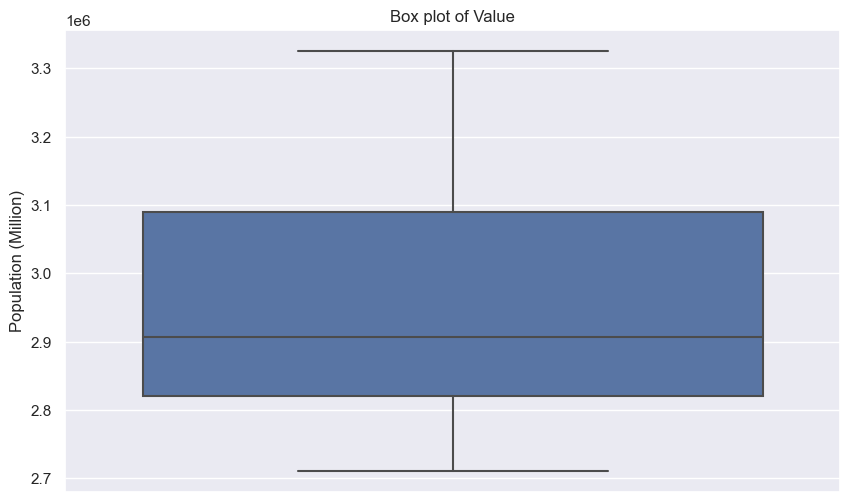

In [47]:
# If we need to focus on the data starting from the year 2010, we can filter it with the following line.
# BothSexes_AllAges = BothSexes_AllAges[BothSexes_AllAges["Year"] >= 2010]

# We're plotting a boxplot for the 'Value' variable, which represents the annual total population.
plt.figure(figsize=(10, 6))  # We set the figure size to 10 by 6 inches for better visibility.
sns.boxplot(y=all_ages["Value"])  # We use seaborn's boxplot function, setting 'y' to the 'Value' column.
plt.title("Box plot of Value")  # We add a title to the plot.
plt.ylabel("Population (Million)")  # We label the y-axis as 'Population (Million)'.
plt.show()  # We display the plot.

In [48]:
# We exclude the 'Both sexes' category for the selected year and age group.
df_filtered= df[(df["Year"] == 2022) & (df["Age Group"] == "All ages")]
df_filtered2= df2[(df2["Year"] == 2022) & (df2["Age Group"] == "All ages")]
# We calculate the total 'Value' for each sex within the selected year.
combined_df = pd.concat([df_filtered, df_filtered2], axis=0)
combined_df['Country'] = ['Ireland'] * len(df_filtered) + ['Netherlands'] * len(df_filtered2)
combined_df

,Year,Age Group,Value,Country
79,2022,All ages,3325487,Ireland
79,2022,All ages,2524888,Netherlands


In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

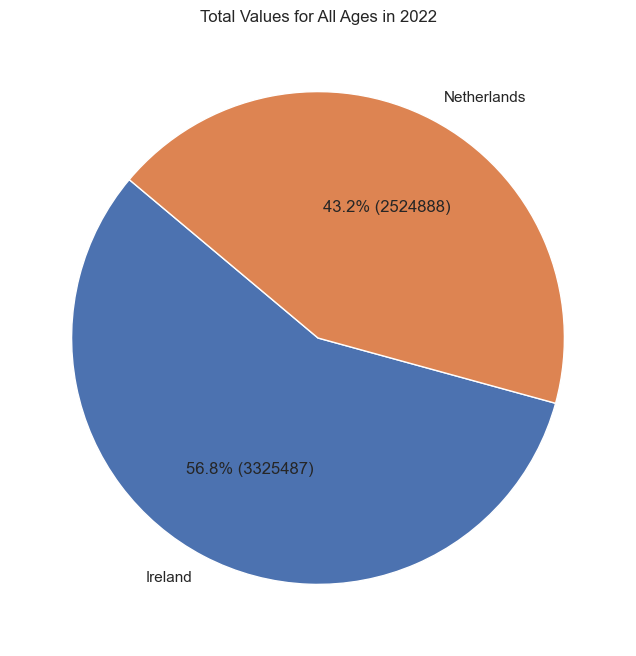

In [50]:
ireland_total = df[(df["Year"] == 2022) & (df["Age Group"] == "All ages")]["Value"].sum()
netherlands_total = df2[(df2["Year"] == 2022) & (df2["Age Group"] == "All ages")]["Value"].sum()
values = [ireland_total, netherlands_total]
labels = ['Ireland', 'Netherlands']
total = sum(values)

plt.figure(figsize=(8, 8))
#plt.pie(values, labels=labels, autopct=autopct_format(values), startangle=140)
plt.pie(values, labels=labels,
        autopct=lambda pct: '{:.1f}% ({:.0f})'.format(pct, pct * total / 100),startangle=140)
plt.title('Total Values for All Ages in 2022')
plt.show()

In [51]:
filtered_data = df[(df['Year'] == year) & (df["Age Group"]=="All ages")]
values = filtered_data.iloc[0,1:].tolist()
values

['All ages', 3325487]

Dropdown(description='Year:', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), value=2014)

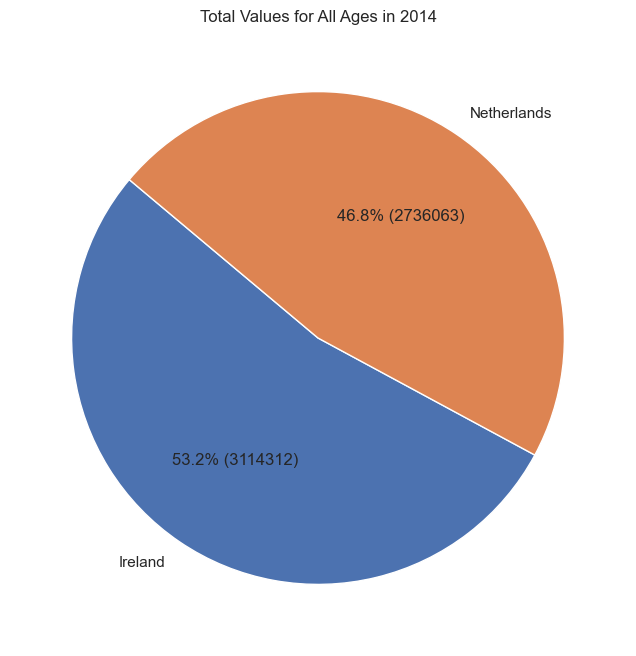

In [52]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Yıllara göre toplam değerleri hesaplayın
ireland_totals = all_ages.groupby('Year')['Value'].sum()
netherlands_totals = all_ages2.groupby('Year')['Value'].sum()

# Yılları ve toplam değerleri içeren bir DataFrame oluşturun
df_totals = pd.DataFrame({
    'Year': ireland_totals.index,
    'Ireland': ireland_totals.values,
    'Netherlands': netherlands_totals.values
})

# Yıllar için dropdown widget'ını oluştur
year_dropdown_pie_chart = widgets.Dropdown(
    options=df_totals['Year'].unique().tolist(),
    description='Year:',
    disabled=False,
)

# Pie chart çizdirme fonksiyonu
def plot_pie_chart(year):
    filtered_data = df_totals[df_totals['Year'] == year]
    values = filtered_data.iloc[0, 1:].tolist()
    labels = filtered_data.columns[1:].tolist()
    plt.figure(figsize=(8, 8))
    #plt.pie(values, labels=labels,colors = ['green', 'darkorange'], autopct='%1.1f%%', startangle=140)
    plt.pie(values, labels=labels,
        autopct=lambda pct: '{:.1f}% ({:.0f})'.format(pct, pct * total / 100),startangle=140)
    plt.title(f'Total Values for All Ages in {year}')
    plt.show()

# Dropdown değiştiğinde çalışacak fonksiyon
def on_year_change(change):
    clear_output(wait=True)
    display(year_dropdown)
    plot_pie_chart(change.new)

# Dropdown widget'ını göster ve callback fonksiyonunu bağla
display(year_dropdown_pie_chart)
year_dropdown_pie_chart.observe(on_year_change, names='value')

# İlk pie chart'ı varsayılan yıl için çiz
plot_pie_chart(df_totals['Year'].iloc[0])


In [53]:
# plt.figure(figsize=(10, 6)) # Set the figure size for the scatter plot


# # Create a scatter plot with 'Age Group' on the x-axis and 'Value' on the y-axis
# sns.scatterplot(x=df['Age Group'], y=df['Value'])

# # Calculate the rounded minimum value for y-ticks based on the filtered data
# # Multiply by 2 and divide by 2 for rounding to the nearest 0.5
# rounded_min_value = math.ceil(min(df["Value"]) * 2) / 2

# step=0.5 # Set the step size for the y-tick intervals
# # Create a list of y-tick values starting from the rounded minimum value to the maximum value with steps
# values = list(np.arange(rounded_min_value, round(max(df["Value"]), 2), step))
# # Insert the actual minimum and maximum values into the list for accurate y-tick labels
# values.insert(0, round(min(df["Value"]), 3))
# values.append(round(max(df["Value"]), 3))


# plt.yticks(ticks=values) # Set the y-tick values to the rounded values
# plt.title('Age Group and Population Relationship') # Set the title of the scatter plot
# plt.xlabel('Age Group') # Set the label for the x-axis
# plt.ylabel('Value (Million)') # Set the label for the y-axis
# plt.show() # Display the plot


In [54]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Dropdown widget'ları oluşturun
country_dropdown_line_plot = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_line_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_line_plot = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_line_plot(change):
    with output_line_plot:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_country = country_dropdown_line_plot.value
        selected_age_group = age_group_dropdown_line_plot.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_line_plot = data[data['Age Group'] == selected_age_group]
        sns.lineplot(data=data_line_plot, x="Year", y="Value")
        plt.title(f"{selected_country} - {selected_age_group}")
        plt.ylabel('Value')
        plt.xlabel('Year')
        plt.show()

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
country_dropdown_line_plot.observe(update_line_plot, names='value')
age_group_dropdown_line_plot.observe(update_line_plot, names='value')

# Widget'ları ve çıktı alanını göster
display(country_dropdown_line_plot, age_group_dropdown_line_plot, output_line_plot)
update_line_plot(None)  # İlk grafik


Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

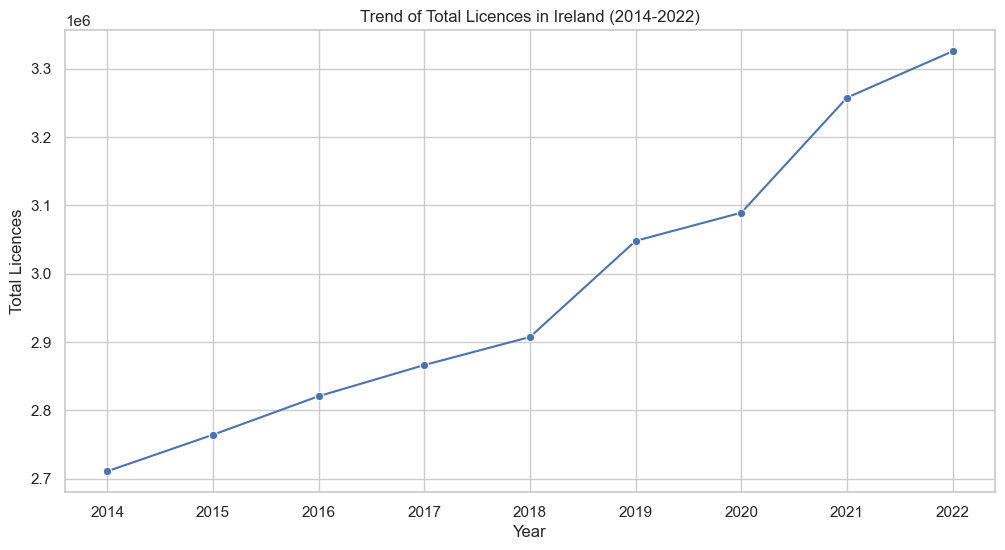

In [55]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Trend analysis for Ireland: Total Licences over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_ages, x="Year", y="Value", ci=None, marker='o')
plt.title("Trend of Total Licences in Ireland (2014-2022)")
plt.ylabel("Total Licences")
plt.xlabel("Year")
plt.show()

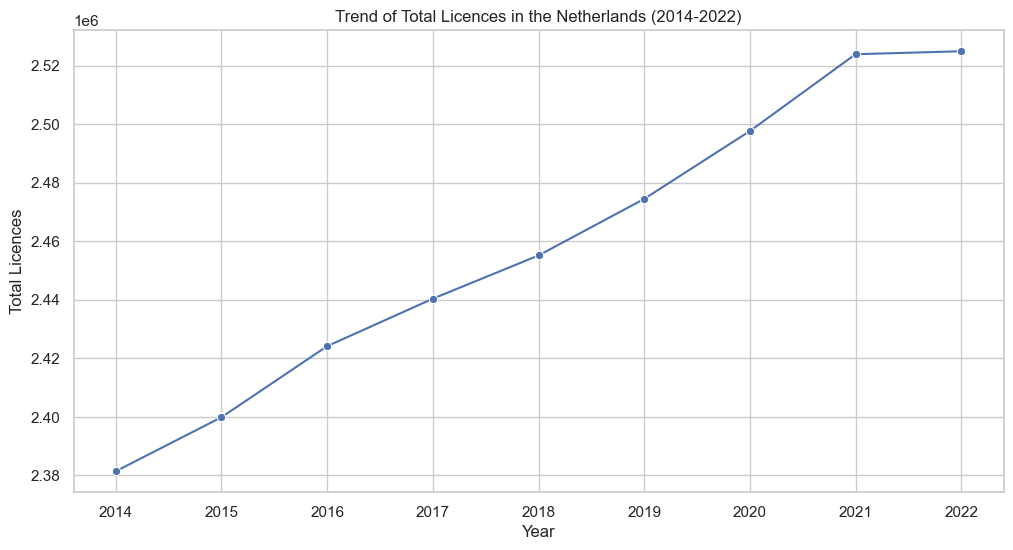

In [56]:
# Trend analysis for Netherlands: Total Licences over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_ages2, x="Year", y="Value", ci=None, marker='o')
plt.title("Trend of Total Licences in the Netherlands (2014-2022)")
plt.ylabel("Total Licences")
plt.xlabel("Year")
plt.show()

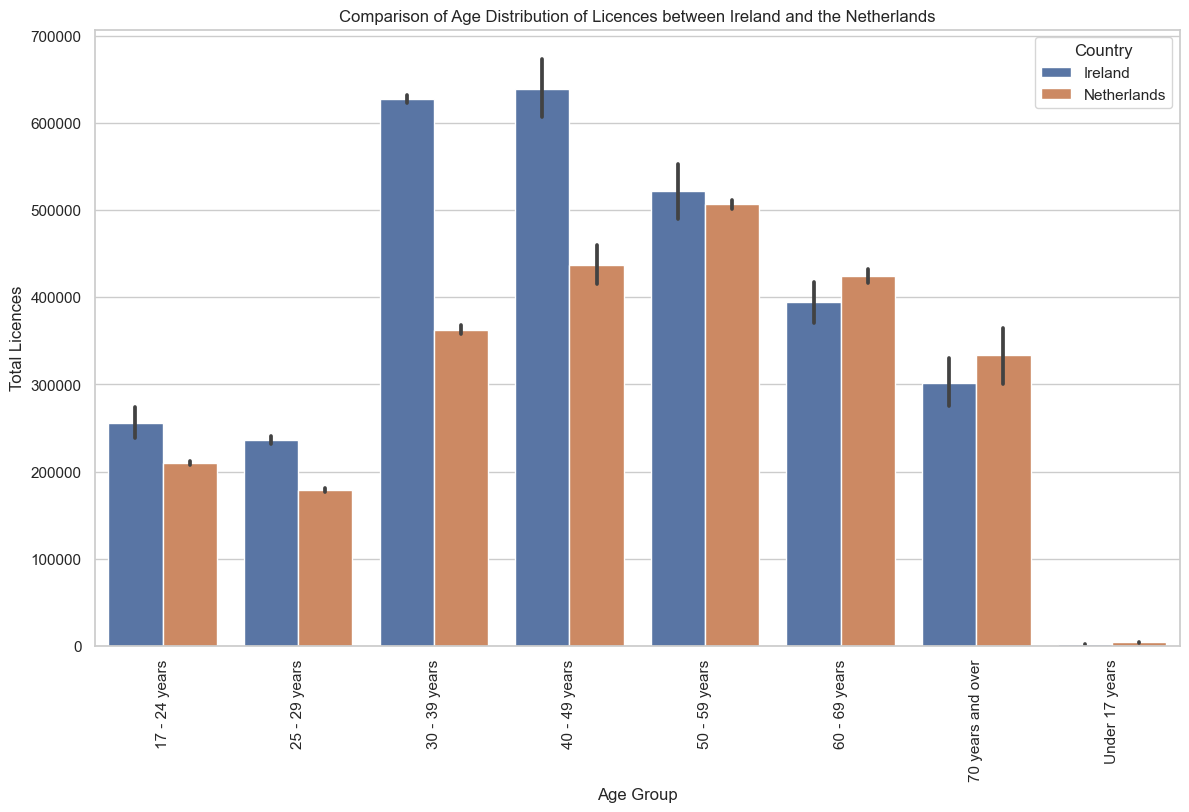

In [105]:
# Comparison of age distributions between Ireland and the Netherlands
# Concatenating the two datasets for comparison, adding a 'Country' column
df_barplot=df[df["Age Group"] != "All ages"]
df2_barplot=df2[df2["Age Group"] != "All ages"]
df_barplot['Country'] = 'Ireland'
df2_barplot['Country'] = 'Netherlands'
combined_df = pd.concat([df_barplot, df2_barplot])

# Plotting age distribution comparison
plt.figure(figsize=(14, 8))
sns.barplot(data=combined_df, x="Age Group", y="Value", hue="Country")
plt.title("Comparison of Age Distribution of Licences between Ireland and the Netherlands")
plt.ylabel("Total Licences")
plt.xlabel("Age Group")
plt.xticks(rotation=90)
plt.show()


# çıkarımsal istatistik testleri

## 1. Normal Dağılım Testi (Shapiro-Wilk Testi)

Shapiro-Wilk testi hipotest

    1- Null Hipotezi (H0): Yaş grubunun ehliyet sahiplerinin sayıları normal dağılım gösterir.
    2- Alternatif Hipotez (H1): Yaş grubunun ehliyet sahiplerinin sayıları normal dağılım göstermez.

Bu hipotezler, İrlanda ve Hollanda veri setlerindeki her bir yaş grubu için ayrı ayrı test edilecek. Shapiro-Wilk testi, p-değerine dayanarak null hipotezin reddedilip reddedilmeyeceğini belirler. Eğer p-değeri belirlenen anlamlılık eşiğinden (0.05) düşükse, bu durumda null hipotezi reddedilir ve verilerin normal dağılım göstermediği sonucuna varılır.

In [58]:
from scipy.stats import shapiro

# Shapiro-Wilk Test for normality on the 'Value' column of both datasets
shapiro_test_ireland = shapiro(df[df["Age Group"]!="All ages"]['Value'])
shapiro_test_netherlands = shapiro(df2[df2["Age Group"]!="All ages"]['Value'])
if shapiro_test_ireland.pvalue >= 0.05:
        hypothesis_ireland = "H0"
else: hypothesis_ireland = "H1"
print(hypothesis_ireland,f"Shapiro Result; Statistic: {shapiro_test_ireland.statistic:.4f}",
          f"P-value: {shapiro_test_ireland.pvalue:.6f}","Ireland")
if shapiro_test_netherlands.pvalue >= 0.05:
        hypothesis_netherlands = "H0"
else: hypothesis_netherlands = "H1"
print(hypothesis_netherlands,f"Shapiro Result; Statistic: {shapiro_test_netherlands.statistic:.4f}",
          f"P-value: {shapiro_test_netherlands.pvalue:.6f}","Netherlands")

H1 Shapiro Result; Statistic: 0.9272 P-value: 0.000454 Ireland
H1 Shapiro Result; Statistic: 0.9045 P-value: 0.000047 Netherlands


In [101]:
# Shapiro-Wilk Test for normality on the 'Value' column of both datasets
age_group = df["Age Group"].unique()
shapiro_results = {
    "Ireland": [],
    "Netherlands": []
}
for age in age_group: 
    shapiro_test_ireland = shapiro(df[df["Age Group"]==age]['Value'])
    shapiro_results["Ireland"].append((age, shapiro_test_ireland.statistic, shapiro_test_ireland.pvalue))
    shapiro_test_netherlands = shapiro(df2[df2["Age Group"]==age]['Value'])
    shapiro_results["Netherlands"].append((age, shapiro_test_netherlands.statistic, shapiro_test_netherlands.pvalue))
    if shapiro_test_ireland.pvalue  >= 0.05:
        hypothesis_ireland = "H0"
    else: hypothesis_ireland = "H1"
    print(hypothesis_ireland,f"Shapiro; Statistic: {shapiro_test_ireland.statistic:.4f}",
          f"\tP-value: {shapiro_test_ireland.pvalue:.4f}",f"\t{age}","Ireland")
    if shapiro_test_netherlands.pvalue >= 0.05:
        hypothesis_netherlands = "H0"
    else: hypothesis_netherlands = "H1"
    print(hypothesis_netherlands,f"Shapiro; Statistic: {shapiro_test_netherlands.statistic:.4f}",
          f"\tP-value: {shapiro_test_netherlands.pvalue:.4f}",f"\t{age}","Netherlands")

H1 Shapiro; Statistic: 0.7672 	P-value: 0.0086 	17 - 24 years Ireland
H0 Shapiro; Statistic: 0.9329 	P-value: 0.5096 	17 - 24 years Netherlands
H0 Shapiro; Statistic: 0.9333 	P-value: 0.5129 	25 - 29 years Ireland
H0 Shapiro; Statistic: 0.9398 	P-value: 0.5803 	25 - 29 years Netherlands
H0 Shapiro; Statistic: 0.9505 	P-value: 0.6955 	30 - 39 years Ireland
H0 Shapiro; Statistic: 0.8720 	P-value: 0.1290 	30 - 39 years Netherlands
H0 Shapiro; Statistic: 0.9452 	P-value: 0.6371 	40 - 49 years Ireland
H0 Shapiro; Statistic: 0.9588 	P-value: 0.7858 	40 - 49 years Netherlands
H0 Shapiro; Statistic: 0.9305 	P-value: 0.4861 	50 - 59 years Ireland
H0 Shapiro; Statistic: 0.8461 	P-value: 0.0675 	50 - 59 years Netherlands
H0 Shapiro; Statistic: 0.9437 	P-value: 0.6208 	60 - 69 years Ireland
H0 Shapiro; Statistic: 0.9743 	P-value: 0.9286 	60 - 69 years Netherlands
H0 Shapiro; Statistic: 0.9528 	P-value: 0.7204 	70 years and over Ireland
H0 Shapiro; Statistic: 0.9542 	P-value: 0.7358 	70 years and o

In [60]:
# Dropdown widget'ları oluşturun
age_group_dropdown_shapiro = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_shapiro = widgets.Output()

def update_shapiro(change):
    with output_shapiro:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_age_group = age_group_dropdown_shapiro.value
        
        data_shapiro_test = df[df["Age Group"] == selected_age_group]
        data_shapiro_test2 = df2[df2["Age Group"] == selected_age_group]
        # Shapiro-Wilk Test for normality on the 'Value' column of both datasets
        shapiro_test_ireland = shapiro(data_shapiro_test['Value'])
        shapiro_test_netherlands = shapiro(data_shapiro_test2['Value'])
        
        if shapiro_test_ireland.pvalue  >= 0.05:
            hypothesis_ireland = "H0 (normal distribution)"
        else: hypothesis_ireland = "H1 (non normal distribution)"
        if shapiro_test_netherlands.pvalue >= 0.05:
            hypothesis_netherlands = "H0 (normal distribution)"
        else: hypothesis_netherlands = "H1 (non normal distribution)"
        
        print(f"Selected age group= {selected_age_group}\n")
        print(f"Ireland Hypothsis Result: {hypothesis_ireland}")
        print(f"Ireland {shapiro_test_ireland}\n")
        print(f"Netherlands Hypothsis Result: {hypothesis_netherlands}")
        print(f"Netherlands {shapiro_test_netherlands}")

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
age_group_dropdown_shapiro.observe(update_shapiro, names='value')

# Widget'ları ve çıktı alanını göster
display(age_group_dropdown_shapiro, output_shapiro)
update_shapiro(None)  # İlk grafik

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

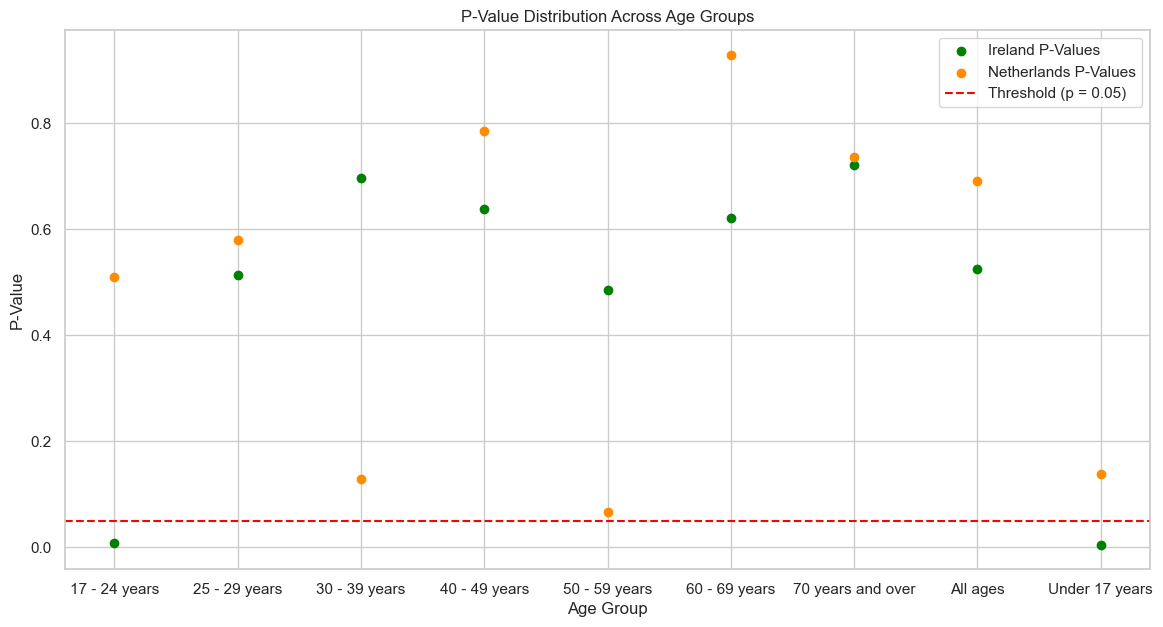

In [61]:
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt


# Shapiro-Wilk test sonuçlarını saklamak için boş listeler oluşturalım
shapiro_results = {
    "Ireland": [],
    "Netherlands": []
}
age_groups=df['Age Group'].unique()
# Her bir yaş grubu için Shapiro-Wilk testi yapalım
for age in age_groups:
    # Ireland verisi için
    shapiro_test_ireland = shapiro(df[df["Age Group"] == age]['Value'])
    shapiro_results["Ireland"].append((age, shapiro_test_ireland.statistic, shapiro_test_ireland.pvalue))
    
    # Netherlands verisi için
    shapiro_test_netherlands = shapiro(df2[df2["Age Group"] == age]['Value'])
    shapiro_results["Netherlands"].append((age, shapiro_test_netherlands.statistic, shapiro_test_netherlands.pvalue))

# P-Value Dağılım Grafiği
plt.figure(figsize=(14, 7))
for country, color in zip(shapiro_results, ['green', 'darkorange']):
    ages, _, p_values = zip(*shapiro_results[country])
    plt.scatter(ages, p_values, color=color, label=f'{country} P-Values')
plt.axhline(0.05, color='red', linestyle='--', label='Threshold (p = 0.05)')
plt.xlabel('Age Group')
plt.ylabel('P-Value')
plt.title('P-Value Distribution Across Age Groups')
plt.legend()
plt.show()

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dropdown widget'ları oluşturun
country_dropdown_dist_value = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_dist_value = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_dist_value= widgets.Output()

# Grafik güncelleme fonksiyonu
def update_dist_value(change):
    with output_dist_value:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_country = country_dropdown_dist_value.value
        selected_age_group = age_group_dropdown_dist_value.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_dist_value = data[data['Age Group'] == selected_age_group]
        sns.histplot(data_dist_value["Value"], kde=True, bins=9)
        plt.title(f"Distribution of Licence Values for {selected_age_group} Age Group in the {selected_country}")
        plt.xticks(rotation=90)
        plt.show()
        
# Dropdown widget'larının değişikliklerine göre grafik güncelleme
country_dropdown_dist_value.observe(update_dist_value, names='value')
age_group_dropdown_dist_value.observe(update_dist_value, names='value')

# Widget'ları ve çıktı alanını göster
display(country_dropdown_dist_value, age_group_dropdown_dist_value, output_dist_value)
update_dist_value(None)  # İlk grafik

Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

In [63]:
# Additionally, plotting a Q-Q plot to visually assess the normality
import scipy.stats as stats


# Dropdown widget'ları oluşturun
country_dropdown_qq_plot = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_qq_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_qq_plot = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_qq_plot(change):
    with output_qq_plot:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_country = country_dropdown_qq_plot.value
        selected_age_group = age_group_dropdown_qq_plot.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_qq_plot = data[data['Age Group'] == selected_age_group]
        stats.probplot(data_qq_plot['Value'], dist="norm", plot=plt)
        plt.title(f"Q-Q Plot for {selected_age_group} Age Group in the {selected_country}")
        plt.show()
# Dropdown widget'larının değişikliklerine göre grafik güncelleme
country_dropdown_qq_plot.observe(update_qq_plot, names='value')
age_group_dropdown_qq_plot.observe(update_qq_plot, names='value')

# Widget'ları ve çıktı alanını göster
display(country_dropdown_qq_plot, age_group_dropdown_qq_plot, output_qq_plot)
update_qq_plot(None)  # İlk grafik

Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

## 2. T-Testi

### T-Testi Hipotezi:
    Null Hipotezi (H0): İki grubun ortalamaları arasında istatistiksel olarak anlamlı bir fark yoktur.
    Alternatif Hipotezi (H1): İki grubun ortalamaları arasında istatistiksel olarak anlamlı bir fark vardır.
    
    Null Hipotezi (H0): There is no statistically significant difference between the means of the two groups.
    Alternatif Hipotezi (H1): There is a statistically significant difference between the means of the two groups.

In [65]:
from scipy.stats import ttest_ind

# Performing Welch's T-test (which does not assume equal variances) between Ireland and Netherlands for the year 2014
ttest_result = ttest_ind(df[df["Age Group"]!="All ages"]['Value'],
                          df2[df2["Age Group"]!="All ages"]['Value'], equal_var=False)
if ttest_result.pvalue  >= 0.05:
    hypothesis_ttest = "H0 (There is no statistically significant difference between the means of the two groups.)"
else: hypothesis_ttest = "H1 (There is a statistically significant difference between the means of the two groups.)"
ttest_result
print(f"Hypothsis Result: {hypothesis_ttest}\n")
print(f"T-test Result;\nStatistic:{ttest_result.statistic:.5f}\nPvalue:\t{ttest_result.pvalue:.5f}\ndf:\t{ttest_result.df:5f}\n")

Hypothsis Result: H1 (There is a statistically significant difference between the means of the two groups.)

T-test Result;
Statistic:2.10303
Pvalue:	0.03736
df:	132.259532



In [66]:
# Dropdown widget'ları oluşturun
age_group_dropdown_ttest = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_ttest = widgets.Output()

def update_ttest(change):
    with output_ttest:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_age_group = age_group_dropdown_ttest.value
        
        # Performing T-test between Ireland and Netherlands for the spesific age group
        ttest_result = ttest_ind(df[df["Age Group"]==selected_age_group]['Value'],
                          df2[df2["Age Group"]==selected_age_group]['Value'], equal_var=False)
        
        if ttest_result.pvalue  >= 0.05:
            hypothesis_ttest = "H0 (There is no statistically significant difference between the means of the two groups.)"
        else: hypothesis_ttest = "H1 (There is a statistically significant difference between the means of the two groups.)"
        
        print(f"Selected age group= {selected_age_group}\n")
        print(f"Hypothsis Result: {hypothesis_ttest}\n")
        print(f"T-test Result;\nStatistic:{ttest_result.statistic:.5f}\nPvalue:\t{ttest_result.pvalue:.5f}\ndf:\t{ttest_result.df:5f}\n")

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
age_group_dropdown_ttest.observe(update_ttest, names='value')

# Widget'ları ve çıktı alanını göster
display(age_group_dropdown_ttest, output_ttest)
update_ttest(None)  # İlk grafik

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

In [76]:
# Re-loading the datasets due to the reset of the execution state
df_ireland = df
df_netherlands = df2

# Creating the Dropdown widget for selecting the age group
age_group_dropdown_box_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

def update_box_plot_side_by_side(change):
    selected_age_group = age_group_dropdown_box_plot.value
    with output_box_plot:
        clear_output(wait=True)

        # Filtering the combined data for the selected age group
        # Filtering the combined data for the selected age group
        filtered_data_ireland = df_ireland[df_ireland['Age Group'] == selected_age_group]
        filtered_data_netherlands = df_netherlands[df_netherlands['Age Group'] == selected_age_group]

        # Creating subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Plotting the boxplot for Ireland on the first subplot
        sns.boxplot(y='Value', data=filtered_data_ireland, ax=axes[0])
        axes[0].set_title(f'Ireland - {selected_age_group}')
        
        # Plotting the boxplot for Netherlands on the second subplot
        sns.boxplot(y='Value', data=filtered_data_netherlands, ax=axes[1])
        axes[1].set_title(f'Netherlands - {selected_age_group}')
        
        # Display the plot
        plt.tight_layout()
        plt.show()

# Reassign the observe function to the new function that plots side by side
#age_group_dropdown_box_plot.unobserve(update_box_plot, names='value')
age_group_dropdown_box_plot.observe(update_box_plot_side_by_side, names='value')

# Displaying the widgets and re-initializing the plot
display(age_group_dropdown_box_plot, output_box_plot)
update_box_plot_side_by_side(None)  # Trigger the initial plot for side by side view


Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1500x600 with 2 Axes>', '…

## 3. ANOVA (Varyans Analizi) (Parametrik)

- Null Hipotezi (H0): Grupların tüm ortalamaları (popülasyon ortalamaları) arasında bir fark yoktur. Başka bir deyişle, tüm gruplar aynı popülasyonun parçasıdır ve bu nedenle ortalamaları esasında eşittir.

- Alternatif Hipotezi (H1): En az iki grup arasında ortalama farkı vardır. Bu, gruplardan en az birinin diğerlerinden farklı bir popülasyonun parçası olduğunu gösterir.

In [121]:
from scipy.stats import f_oneway
# Prepare the data for ANOVA
anova_results = {}
df_f_oneway=df[df["Age Group"] != "All ages"]["Value"]
df2_f_oneway=df2[df2["Age Group"] != "All ages"]["Value"]
f_stat, p_value = f_oneway(df_f_oneway, df2_f_oneway)
anova_results = {'F-Statistic': f_stat, 'p-value': p_value}
print(f"F-Statistic: {f_stat:.4f}",f"\tP-Value: {p_value:.4f}")

F-Statistic: 4.4228 	P-Value: 0.0372


In [92]:
# Prepare the data for ANOVA
anova_results = {}
#age_groups = df["Age Group"].unique()

for age_group in age_groups:
    # Get the values for Ireland and Netherlands for this age group
    ireland_values = df[df["Age Group"] == age_group]["Value"]
    netherlands_values = df2[df2["Age Group"] == age_group]["Value"]
    
    # Perform ANOVA (Analysis of Variance) test
    f_stat, p_value = f_oneway(ireland_values, netherlands_values)
    anova_results[age_group] = {'F-Statistic': f_stat, 'p-value': p_value}
    print(f"F-Statistic {f_stat:.4f}",f"\tP-Value {p_value:.4f}",f"\t\t{age_group}")


F-Statistic 22.0162 	P-Value 0.0002 		17 - 24 years
F-Statistic 428.5690 	P-Value 0.0000 		25 - 29 years
F-Statistic 5084.0063 	P-Value 0.0000 		30 - 39 years
F-Statistic 86.0949 	P-Value 0.0000 		40 - 49 years
F-Statistic 0.6134 	P-Value 0.4449 		50 - 59 years
F-Statistic 4.4470 	P-Value 0.0511 		60 - 69 years
F-Statistic 1.7742 	P-Value 0.2015 		70 years and over
F-Statistic 48.7577 	P-Value 0.0000 		All ages
F-Statistic 48.6462 	P-Value 0.0000 		Under 17 years


## 4. Mann-Whitney U Testi

In [ ]:
from scipy.stats import mannwhitneyu

# Selecting the data for the year 2014 from both datasets
ireland_2014 = df[df["Year"] == 2014]["Value"]
netherlands_2014 = df2[df2["Year"] == 2014]["Value"]

# Performing Mann-Whitney U Test between Ireland and Netherlands for the year 2014
mannwhitney_test_2014 = mannwhitneyu(ireland_2014, netherlands_2014)

mannwhitney_test_2014


In [ ]:
from scipy.stats import mannwhitneyu
years=df["Year"].unique()
# Performing Mann-Whitney U Test between Ireland and Netherlands for the years
for year in years:
    ireland_years = df[df["Year"] == year]["Value"]
    netherlands_years = df2[df2["Year"] == year]["Value"]
    mannwhitney_test_years = mannwhitneyu(ireland_years, netherlands_years)
    print(year,"=",mannwhitney_test_years)

In [ ]:
from scipy.stats import mannwhitneyu
years=df["Year"].unique()
# Performing Mann-Whitney U Test between Ireland and Netherlands for the years 
for year in years:
    ireland_years = df_except_all_ages[df_except_all_ages["Year"] == year]["Value"]
    netherlands_years = df2_except_all_ages[df2_except_all_ages["Year"] == year]["Value"]
    mannwhitney_test_years = mannwhitneyu(ireland_years, netherlands_years)
    print(year,"=",mannwhitney_test_years)

In [ ]:
# Performing Mann-Whitney U Test on the entire datasets for 'Value' column
mannwhitney_test_result = mannwhitneyu(df['Value'], df2['Value'])
print("Results with whole data set")
print(f"mannwhitney Statistic Result= {mannwhitney_test_result.statistic}")
print(f"mannwhitney p-value Result= {round(mannwhitney_test_result.pvalue,4)}")

In [ ]:
# Performing Mann-Whitney U Test on the entire datasets for 'Value' column
mannwhitney_test_result_except_all_ages = mannwhitneyu(df_except_all_ages['Value'], df2_except_all_ages['Value'])
print("Results with 'All ages' age group removed from the data set")
print(f"mannwhitney Statistic Result= {mannwhitney_test_result_except_all_ages.statistic}")
print(f"mannwhitney p-value Result= {round(mannwhitney_test_result_except_all_ages.pvalue,4)}")

In [ ]:
# Dropdown widget'ları oluşturun
age_group_dropdown_mannwhitney = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_mannwhitney = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_mannwhitney(change):
    with output_mannwhitney:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_age_group = age_group_dropdown_mannwhitney.value

        data_mannwhitney = df[df["Age Group"] == selected_age_group]
        data_mannwhitney2 = df2[df2["Age Group"] == selected_age_group]
        mannwhitney_test_result= mannwhitneyu(data_mannwhitney['Value'], data_mannwhitney2['Value'])
        print(f"Selected age group= {selected_age_group}\n")
        print(f"mannwhitney Statistic Result= {mannwhitney_test_result.statistic}")
        print(f"mannwhitney p-value Result= {round(mannwhitney_test_result.pvalue,5)}")
# Dropdown widget'larının değişikliklerine göre grafik güncelleme
age_group_dropdown_mannwhitney.observe(update_mannwhitney, names='value')

# Widget'ları ve çıktı alanını göster
display(age_group_dropdown_mannwhitney, output_mannwhitney)
update_mannwhitney(None)  # İlk grafik

## 5. Kruskal-Wallis H Testi

In [ ]:
from scipy.stats import kruskal

# Extracting values for different age groups in Ireland for the year 2014
age_groups = df['Age Group'].unique()
values_by_age_group = [df[(df['Year'] == 2014) & (df['Age Group'] == age)].Value for age in age_groups]

# Performing Kruskal-Wallis H Test among different age groups in Ireland for the year 2014
kruskal_test = kruskal(*values_by_age_group)

kruskal_test

In [ ]:
# Preparing the data for Kruskal-Wallis H Test
# We'll consider each age group in each country as a separate group for the test

# Extracting the age groups
age_groups = df['Age Group'].unique()

# Preparing an empty list to store the values of each group
values_by_age_group = []

# Extracting values for each age group from both datasets
for age_group in age_groups:
    if age_group != 'All ages':  # Excluding the 'All ages' group
        ireland_values = df[df['Age Group'] == age_group]['Value']
        netherlands_values = df2[df2['Age Group'] == age_group]['Value']
        
        # Appending the values to the list
        values_by_age_group.extend([ireland_values, netherlands_values])
# Performing Kruskal-Wallis H Test across all age groups and countries
kruskal_test_result = kruskal(*values_by_age_group)

kruskal_test_result


In [ ]:
from scipy.stats import kruskal

# Filtering out 'All ages' group from both datasets
df_filtered = df[df['Age Group'] != 'All ages']
df2_filtered = df2[df2['Age Group'] != 'All ages']

# Preparing the data for Kruskal-Wallis H Test
# Extracting the age groups
age_groups = df_filtered['Age Group'].unique()

# Re-performing Kruskal-Wallis H Test across all age groups for both countries
kruskal_test_results = {}

for age_group in age_groups:
    ireland_values = df_filtered[df_filtered['Age Group'] == age_group]['Value']
    netherlands_values = df2_filtered[df2_filtered['Age Group'] == age_group]['Value']

    # Perform Kruskal-Wallis H test for this age group
    H_stat, p_value = kruskal(ireland_values, netherlands_values)
    kruskal_test_results[age_group] = {'H_stat': round(H_stat,4), 'p_value': round(p_value,4)}

kruskal_test_results


## 6. Spearman'ın Sıra Korelasyonu

In [ ]:
from scipy.stats import spearmanr

# Calculating the total number of licences per year in Ireland
total_licences_per_year_ireland = df.groupby('Year')['Value'].sum()

# Performing Spearman's rank correlation between years and total licences in Ireland
spearman_correlation = spearmanr(total_licences_per_year_ireland.index, total_licences_per_year_ireland)

spearman_correlation
